# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import os
import warnings

import datetime

import missingno as msno
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12,4)
mpl.rcParams['figure.dpi']     = 300
sns.set_style('darkgrid')

In [4]:
tqdm.pandas()

# **Contexto**
Você trabalha como Analista de Dados em uma empresa que fornece um serviço de rede social. O acesso ao serviço é concedido por meio de assinaturas mensais e os membros podem interagir por meio de comentários, respostas, adição de amigos e outras ações similares.

Alguns colaboradores perceberam uma alta evasão de membros da plataforma. Para validar tal hipótese, foi disponibilizado a você um conjunto de bases de dados que contempla informações sobre os assinantes e seus eventos na plataforma.


**Você deve:**


 * Validar a hipótese levantada pelos seus colegas
 * Montar uma estratégia para redução do churn com base nos dados fornecidos.
 * Esperamos um enfoque no negócio baseado em métricas e gráficos. 

# Carregamento de tabelas (Data Loading)

In [5]:
path_account      = os.path.join('data','Dataset do Case de Analista_Cientista de Dados','account.csv')
path_event_type   = os.path.join('data','Dataset do Case de Analista_Cientista de Dados','event_type.csv')
path_event        = os.path.join('data','Dataset do Case de Analista_Cientista de Dados','event.csv')
path_subscription = os.path.join('data','Dataset do Case de Analista_Cientista de Dados','subscription.csv')

In [6]:
account      = pd.read_csv(path_account)
event_type   = pd.read_csv(path_event_type)
event        = pd.read_csv(path_event)
subscription = pd.read_csv(path_subscription)

## Diagrama de Tabelas
<img src="img/table_schemas.png" height = 5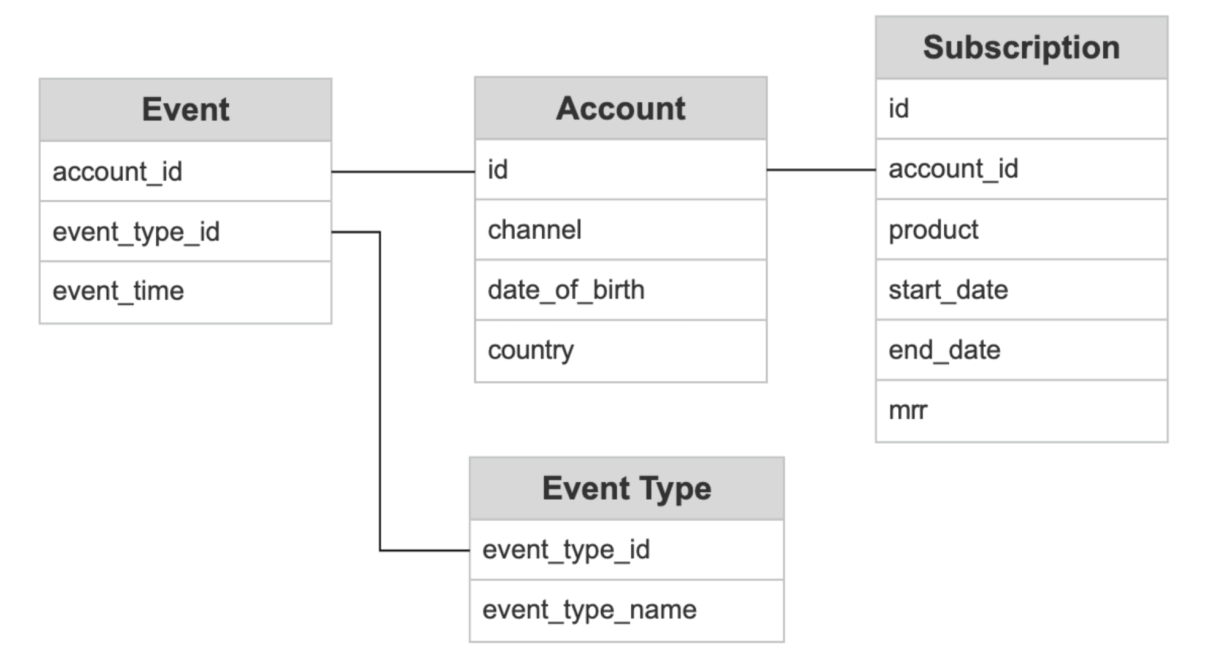00 width = 800>

In [7]:
display(account.head()), account.info()

,id,channel,date_of_birth,country
0,1,appstore2,1948-09-10,CN
1,2,appstore1,1952-11-06,AU
2,3,appstore1,2002-11-10,GB
3,4,appstore1,1976-06-18,US
4,5,appstore1,1975-11-18,KR


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14641 entries, 0 to 14640
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             14641 non-null  int64 
 1   channel        14641 non-null  object
 2   date_of_birth  14641 non-null  object
 3   country        13030 non-null  object
dtypes: int64(1), object(3)
memory usage: 457.7+ KB


(None, None)

In [8]:
display(event_type.head()), account.info()

,event_type_id,event_type_name
0,0,post
1,1,newfriend
2,2,like
3,3,adview
4,4,dislike


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14641 entries, 0 to 14640
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             14641 non-null  int64 
 1   channel        14641 non-null  object
 2   date_of_birth  14641 non-null  object
 3   country        13030 non-null  object
dtypes: int64(1), object(3)
memory usage: 457.7+ KB


(None, None)

In [9]:
display(event.head()), event.info()

,account_id,event_time,event_type_id
0,1,2020-01-06 03:20:00,0
1,1,2020-01-06 00:55:29,0
2,1,2020-01-06 10:16:34,1
3,1,2020-01-06 09:31:16,2
4,1,2020-01-06 20:40:21,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17746587 entries, 0 to 17746586
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   account_id     int64 
 1   event_time     object
 2   event_type_id  int64 
dtypes: int64(2), object(1)
memory usage: 406.2+ MB


(None, None)

In [10]:
display(subscription.head()), subscription.info()

,id,account_id,product,start_date,end_date,mrr
0,0,1,standard,2020-01-06,2020-02-06,9.99
1,1,1,standard,2020-02-06,2020-03-06,9.99
2,2,1,standard,2020-03-06,2020-04-06,9.99
3,3,1,standard,2020-04-06,2020-05-06,9.99
4,4,1,standard,2020-05-06,2020-06-06,9.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55502 entries, 0 to 55501
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          55502 non-null  int64  
 1   account_id  55502 non-null  int64  
 2   product     55502 non-null  object 
 3   start_date  55502 non-null  object 
 4   end_date    55502 non-null  object 
 5   mrr         55502 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ MB


(None, None)

In [11]:
print('*'*5,'Table Shapes', '*'*5, '\n')
(print(f'Tabela account: \t{account.shape[1]} features, {account.shape[0]} registros'))
(print(f'Tabela event_type: \t{event_type.shape[1]} features, {event_type.shape[0]} registros'))
(print(f'Tabela event: \t\t{event.shape[1]} features, {event.shape[0]} registros'))
(print(f'Tabela subscription: \t{subscription.shape[1]} features, {subscription.shape[0]} registros'))

***** Table Shapes ***** 

Tabela account: 	4 features, 14641 registros
Tabela event_type: 	2 features, 8 registros
Tabela event: 		3 features, 17746587 registros
Tabela subscription: 	6 features, 55502 registros


# Pré-processamento dos dados (Data preprocessing)

## Estruturação dos dados (Data Structuring)

Conversão das datas para o formato datetime e conversão de features object para o tipo category para redução do uso de memória.

### Account Table

In [12]:
account.channel.unique()

array(['appstore2', 'appstore1', 'web'], dtype=object)

In [13]:
account.country.unique()

array(['CN', 'AU', 'GB', 'US', 'KR', 'IT', 'MX', 'CO', 'JP', nan, 'BR',
       'DE', 'ES', 'RU', 'AR', 'NO', 'CH', 'SE', 'IN', 'CA', 'ID', 'FR',
       'DK', 'GR', 'NZ', 'PT', 'NL'], dtype=object)

In [14]:
account.id.unique()

array([    1,     2,     3, ..., 14639, 14640, 14641])

In [15]:
account['channel']       = account['channel'].astype('category')
account['country']       = account['country'].astype('category')
account['date_of_birth'] = pd.to_datetime(account['date_of_birth'], format='%Y-%m-%d')

In [16]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14641 entries, 0 to 14640
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14641 non-null  int64         
 1   channel        14641 non-null  category      
 2   date_of_birth  14641 non-null  datetime64[ns]
 3   country        13030 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 258.9 KB


### Event Table

In [17]:
event.columns

Index(['account_id', 'event_time', 'event_type_id'], dtype='object')

In [18]:
event.event_type_id.unique()

array([0, 1, 2, 3, 6, 7, 4, 5])

In [19]:
event['event_type_id'] = event['event_type_id'].astype('category')
event['event_time']    = pd.to_datetime(event['event_time'], format='%Y-%m-%d %H:%M:%S')
event['account_id']    = event['account_id'].astype('category')

In [20]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17746587 entries, 0 to 17746586
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   account_id     category      
 1   event_time     datetime64[ns]
 2   event_type_id  category      
dtypes: category(2), datetime64[ns](1)
memory usage: 186.8 MB


### Event Type Table

In [21]:
event_type.columns

Index(['event_type_id', 'event_type_name'], dtype='object')

In [22]:
event_type.event_type_id.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [23]:
event_type.event_type_name.unique()

array(['post', 'newfriend', 'like', 'adview', 'dislike', 'unfriend',
       'message', 'reply'], dtype=object)

In [24]:
event_type.event_type_id = event_type.event_type_id.astype('category')
event_type.event_type_name = event_type.event_type_name.astype('category')

A tabela apresenta apenas valores únicos e de acordo com o tipo já atribuído, portanto, não há necessidade de conversão de tipos.

### Subscription Table

In [25]:
subscription.head()

,id,account_id,product,start_date,end_date,mrr
0,0,1,standard,2020-01-06,2020-02-06,9.99
1,1,1,standard,2020-02-06,2020-03-06,9.99
2,2,1,standard,2020-03-06,2020-04-06,9.99
3,3,1,standard,2020-04-06,2020-05-06,9.99
4,4,1,standard,2020-05-06,2020-06-06,9.99


In [26]:
subscription['product'].unique()

array(['standard'], dtype=object)

In [27]:
subscription['mrr'].unique()

array([9.99])

In [28]:
subscription['account_id'].unique()

array([    1,     2,     3, ..., 14639, 14640, 14641])

In [29]:
subscription['start_date']    = pd.to_datetime(subscription.start_date, format='%Y-%m-%d')
subscription['end_date']      = pd.to_datetime(subscription.end_date, format='%Y-%m-%d')

subscription['product']       = subscription['product'].astype('category')
subscription['account_id']    = subscription['account_id'].astype('category')

In [30]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55502 entries, 0 to 55501
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          55502 non-null  int64         
 1   account_id  55502 non-null  category      
 2   product     55502 non-null  category      
 3   start_date  55502 non-null  datetime64[ns]
 4   end_date    55502 non-null  datetime64[ns]
 5   mrr         55502 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(1), int64(1)
memory usage: 2.5 MB


## Valores Missing

In [31]:
account.isna().sum()

id                  0
channel             0
date_of_birth       0
country          1611
dtype: int64

In [32]:
event_type.isna().sum()

event_type_id      0
event_type_name    0
dtype: int64

In [33]:
event.isna().sum()

account_id       0
event_time       0
event_type_id    0
dtype: int64

In [34]:
subscription.isna().sum()

id            0
account_id    0
product       0
start_date    0
end_date      0
mrr           0
dtype: int64

Apenas a tabela ***account*** apresenta valores faltantes. São 1611 valores faltantes na coluna do país de origem dos clientes.

In [35]:
(account.country.value_counts())

CN    2241
US    2153
JP     740
BR     725
IN     631
CA     613
GB     595
DE     592
AU     576
MX     523
KR     450
AR     430
FR     417
NZ     318
CO     288
RU     270
ID     159
DK     158
NL     155
ES     153
GR     150
NO     149
IT     143
CH     137
SE     137
PT     127
Name: country, dtype: int64

<AxesSubplot:>

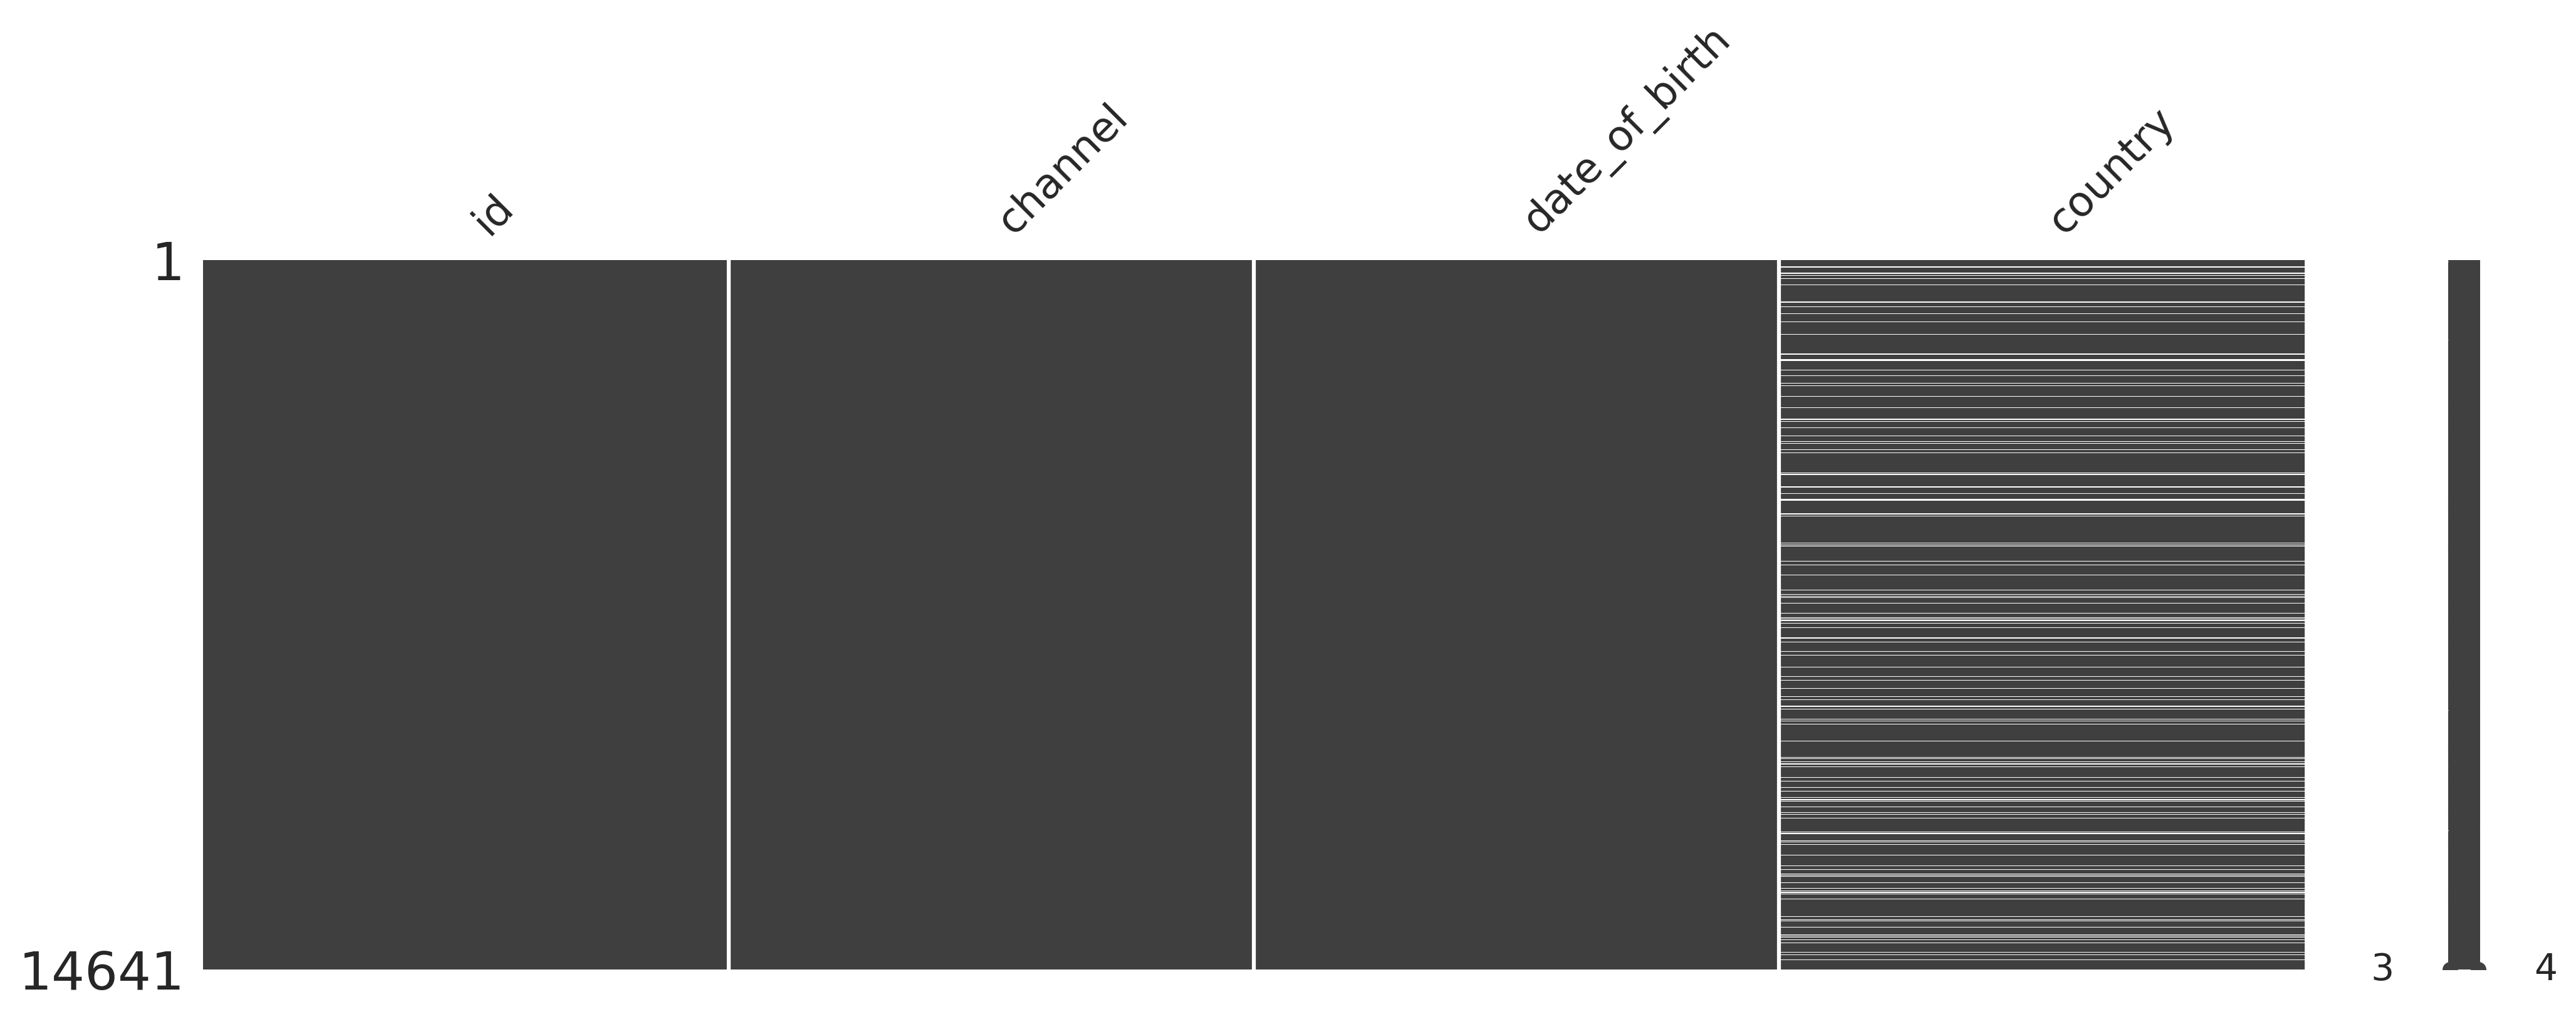

In [36]:
msno.matrix(account, figsize = (16,5))

Como são muitos valores únicos e estão bem distribuídos no dataset, não é possível fazer alguma dedução simples para uma imputação imediata. O tratamento será feito de acordo com a situação que a variável for trabalhada.

## Duplicatas

In [37]:
print(f'Duplicatas em Event: {event.duplicated().sum()}')
print(f'Duplicatas em Account: {account.duplicated().sum()}')
print(f'Duplicatas em Subscription: {subscription.duplicated().sum()}')
print(f'Duplicatas em Event_Type: {event_type.duplicated().sum()}')

Duplicatas em Event: 1296
Duplicatas em Account: 0
Duplicatas em Subscription: 0
Duplicatas em Event_Type: 0


In [38]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17746587 entries, 0 to 17746586
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   account_id     category      
 1   event_time     datetime64[ns]
 2   event_type_id  category      
dtypes: category(2), datetime64[ns](1)
memory usage: 186.8 MB


Considerando que a coluna ***event_time*** da tabela ***event*** dá a precisão em segundos da ocorrência do evento, pode-se considerar as linhas duplicadas nesta tabela como realmente um registro duplo da mesma ocorrência. Sendo assim, portanto, é razoável que sejam retiradas da análise

In [39]:
event.drop_duplicates(inplace = True)

In [40]:
# Preservar RangeIndex para redução do uso de memória
event.reset_index(drop = True, inplace = True)

In [41]:
print(f'Duplicatas em Event: {event.duplicated().sum()}')
print(f'Duplicatas em Account: {account.duplicated().sum()}')
print(f'Duplicatas em Subscription: {subscription.duplicated().sum()}')
print(f'Duplicatas em Event_Type: {event_type.duplicated().sum()}')

Duplicatas em Event: 0
Duplicatas em Account: 0
Duplicatas em Subscription: 0
Duplicatas em Event_Type: 0


In [42]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17745291 entries, 0 to 17745290
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   account_id     category      
 1   event_time     datetime64[ns]
 2   event_type_id  category      
dtypes: category(2), datetime64[ns](1)
memory usage: 186.8 MB


In [43]:
event.head()

,account_id,event_time,event_type_id
0,1,2020-01-06 03:20:00,0
1,1,2020-01-06 00:55:29,0
2,1,2020-01-06 10:16:34,1
3,1,2020-01-06 09:31:16,2
4,1,2020-01-06 20:40:21,2


# Análise Exploratória de Dados (EDA)

A interação dos usuários com a plataforma pode ser estimada pelas interações e eventos gerados pelo log. Então, vamos começar fazendo uma análise do volume de interações no espaço temporal fornecido na tabela ***events***.

In [44]:
print(f'Início: {event.event_time.min()} \nFim: \t{event.event_time.max()}')

Início: 2020-01-01 00:00:01 
Fim: 	2020-06-30 23:59:59


O período analisado ocorre do início do ano de 2020, em janeiro até o término do mês de junho.

In [45]:
event['month'] = event.event_time.dt.month
event.month = event.month.astype('category')

## Volume mensal de interações

In [46]:
month_groupby = event.groupby('month')

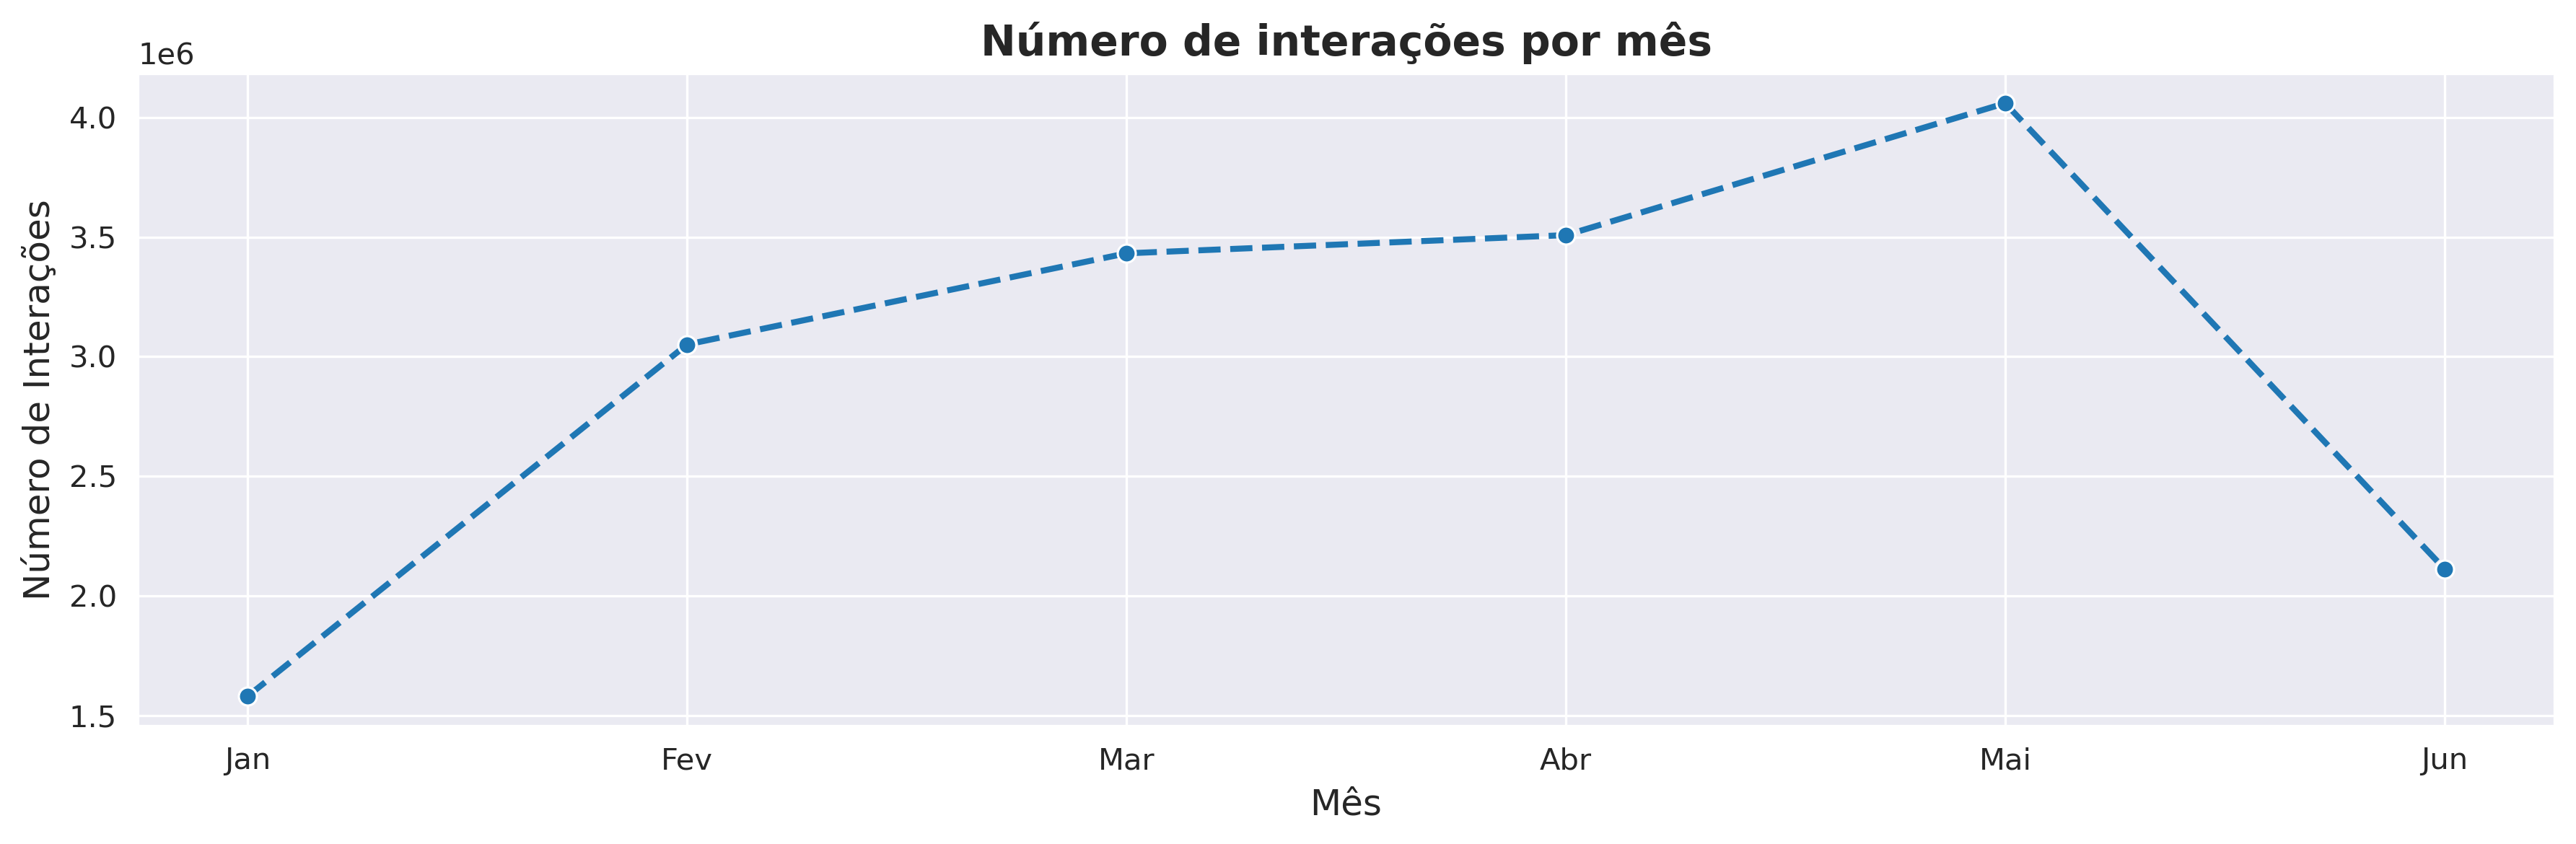

In [47]:
sns.lineplot(x = month_groupby['account_id'].count().index, 
             y=month_groupby['account_id'].count().values, 
             marker = 'o', 
             linewidth=2, 
             linestyle='--')

plt.xticks(ticks = np.arange(1,7), labels = ['Jan','Fev','Mar','Abr','Mai','Jun'])
plt.ylabel('Número de Interações', fontsize = 12)
plt.xlabel('Mês', fontsize = 12)
plt.title('Número de interações por mês', fontdict = {'fontsize':14, 'weight':'bold'})
plt.tight_layout()
plt.show()

O gráfico mostra que o número de interações com a plataforma vinha numa crescente até o mês de maio onde atingiu seu pico. No mês de junho houve uma redução drástica sendo o menor número de interações registrados no mês desde o mês de janeiro.

In [48]:
meses = dict(zip(np.arange(1,7), ['Jan','Fev','Mar','Abr','Mai','Jun']))

In [49]:
grouped_interactions = event.groupby('event_type_id')

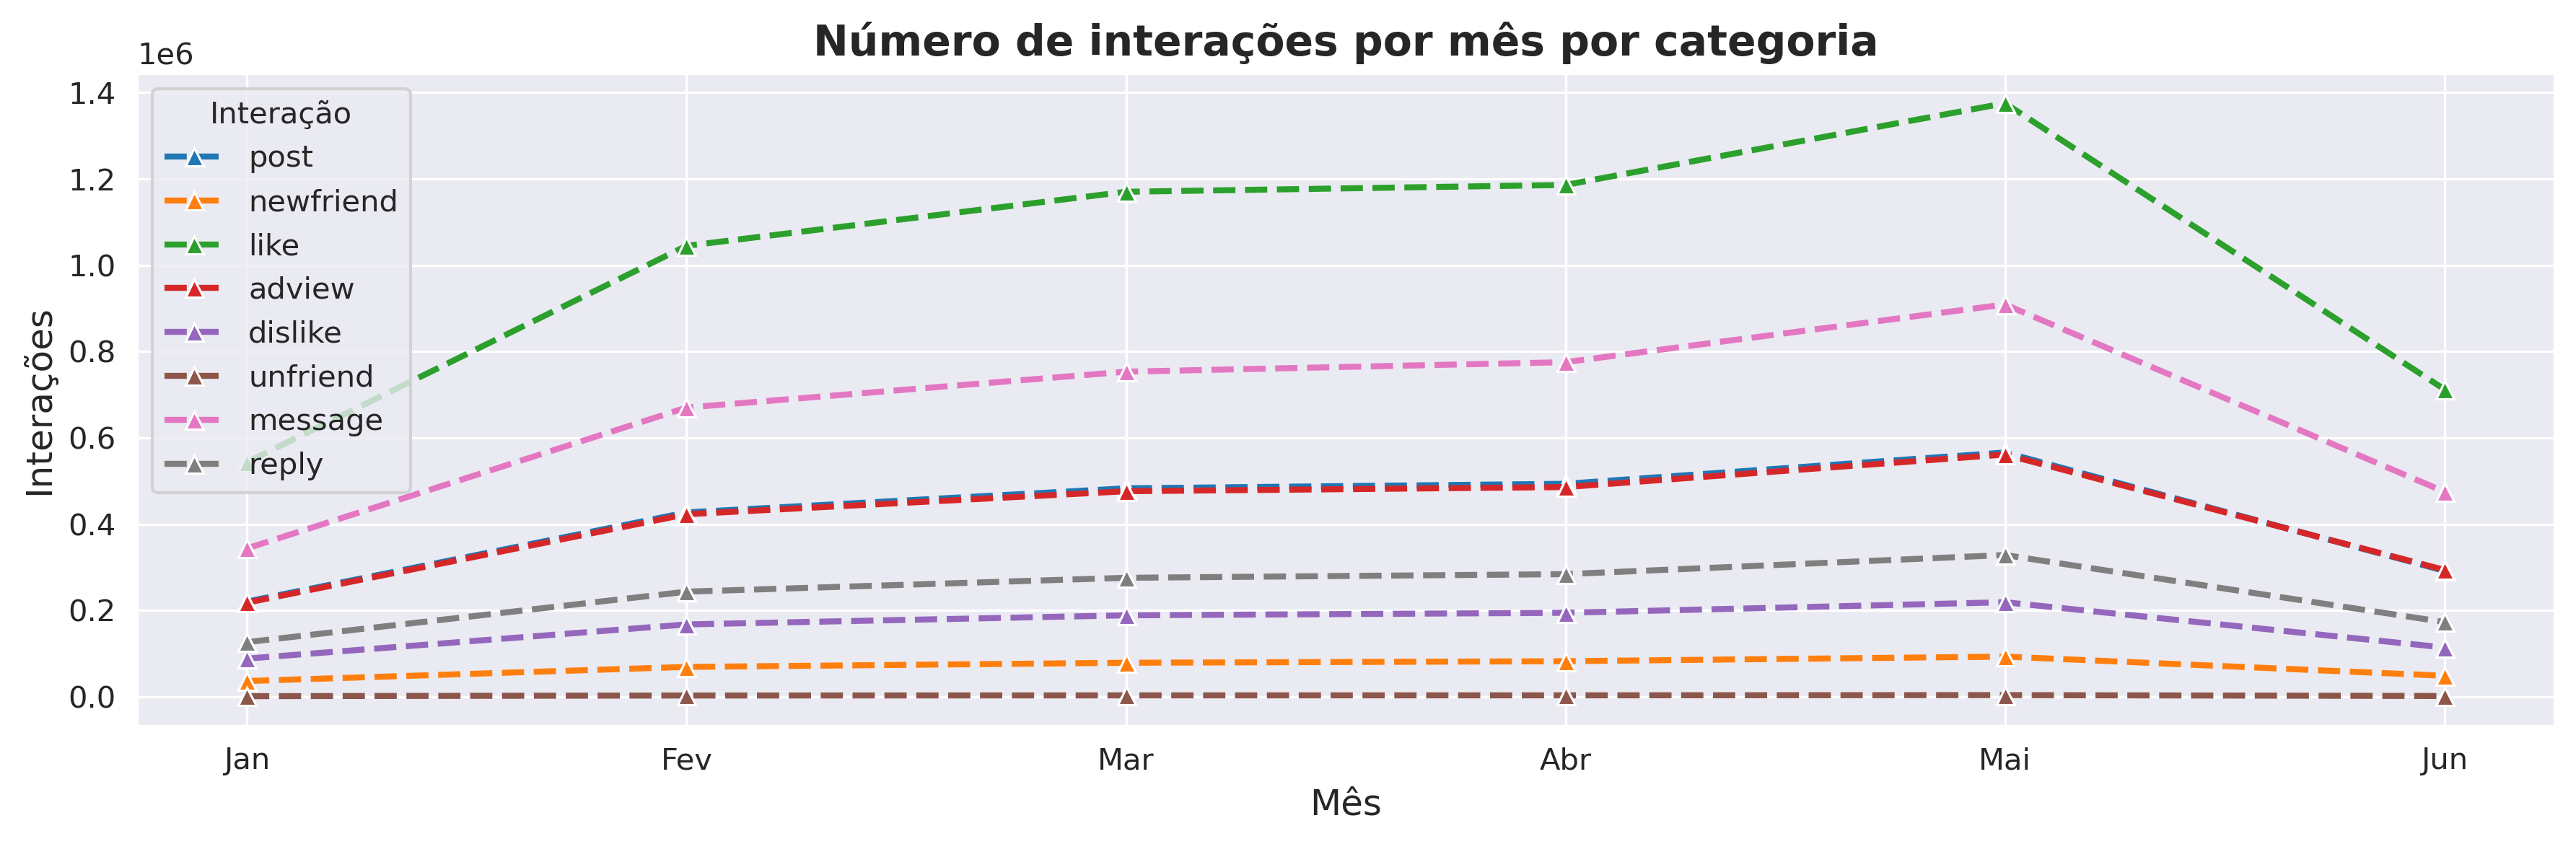

In [50]:
for interaction, group in grouped_interactions:
    
    ax = sns.lineplot(x=group.month.value_counts().index, 
                      y=group.month.value_counts().values, 
                      label = interaction, 
                      marker = '^', 
                      linewidth = 2, 
                      linestyle= '--')

plt.title('Número de interações por mês por categoria', weight = 'bold', fontsize = 14)
ax.set_ylabel('Interações',fontsize=12)
ax.set_xlabel('Mês',fontsize=12)

ax.legend(event_type.event_type_name.unique(), title = 'Interação')
ax.set_xticks(np.arange(1,7), meses.values())
plt.tight_layout()
plt.show()

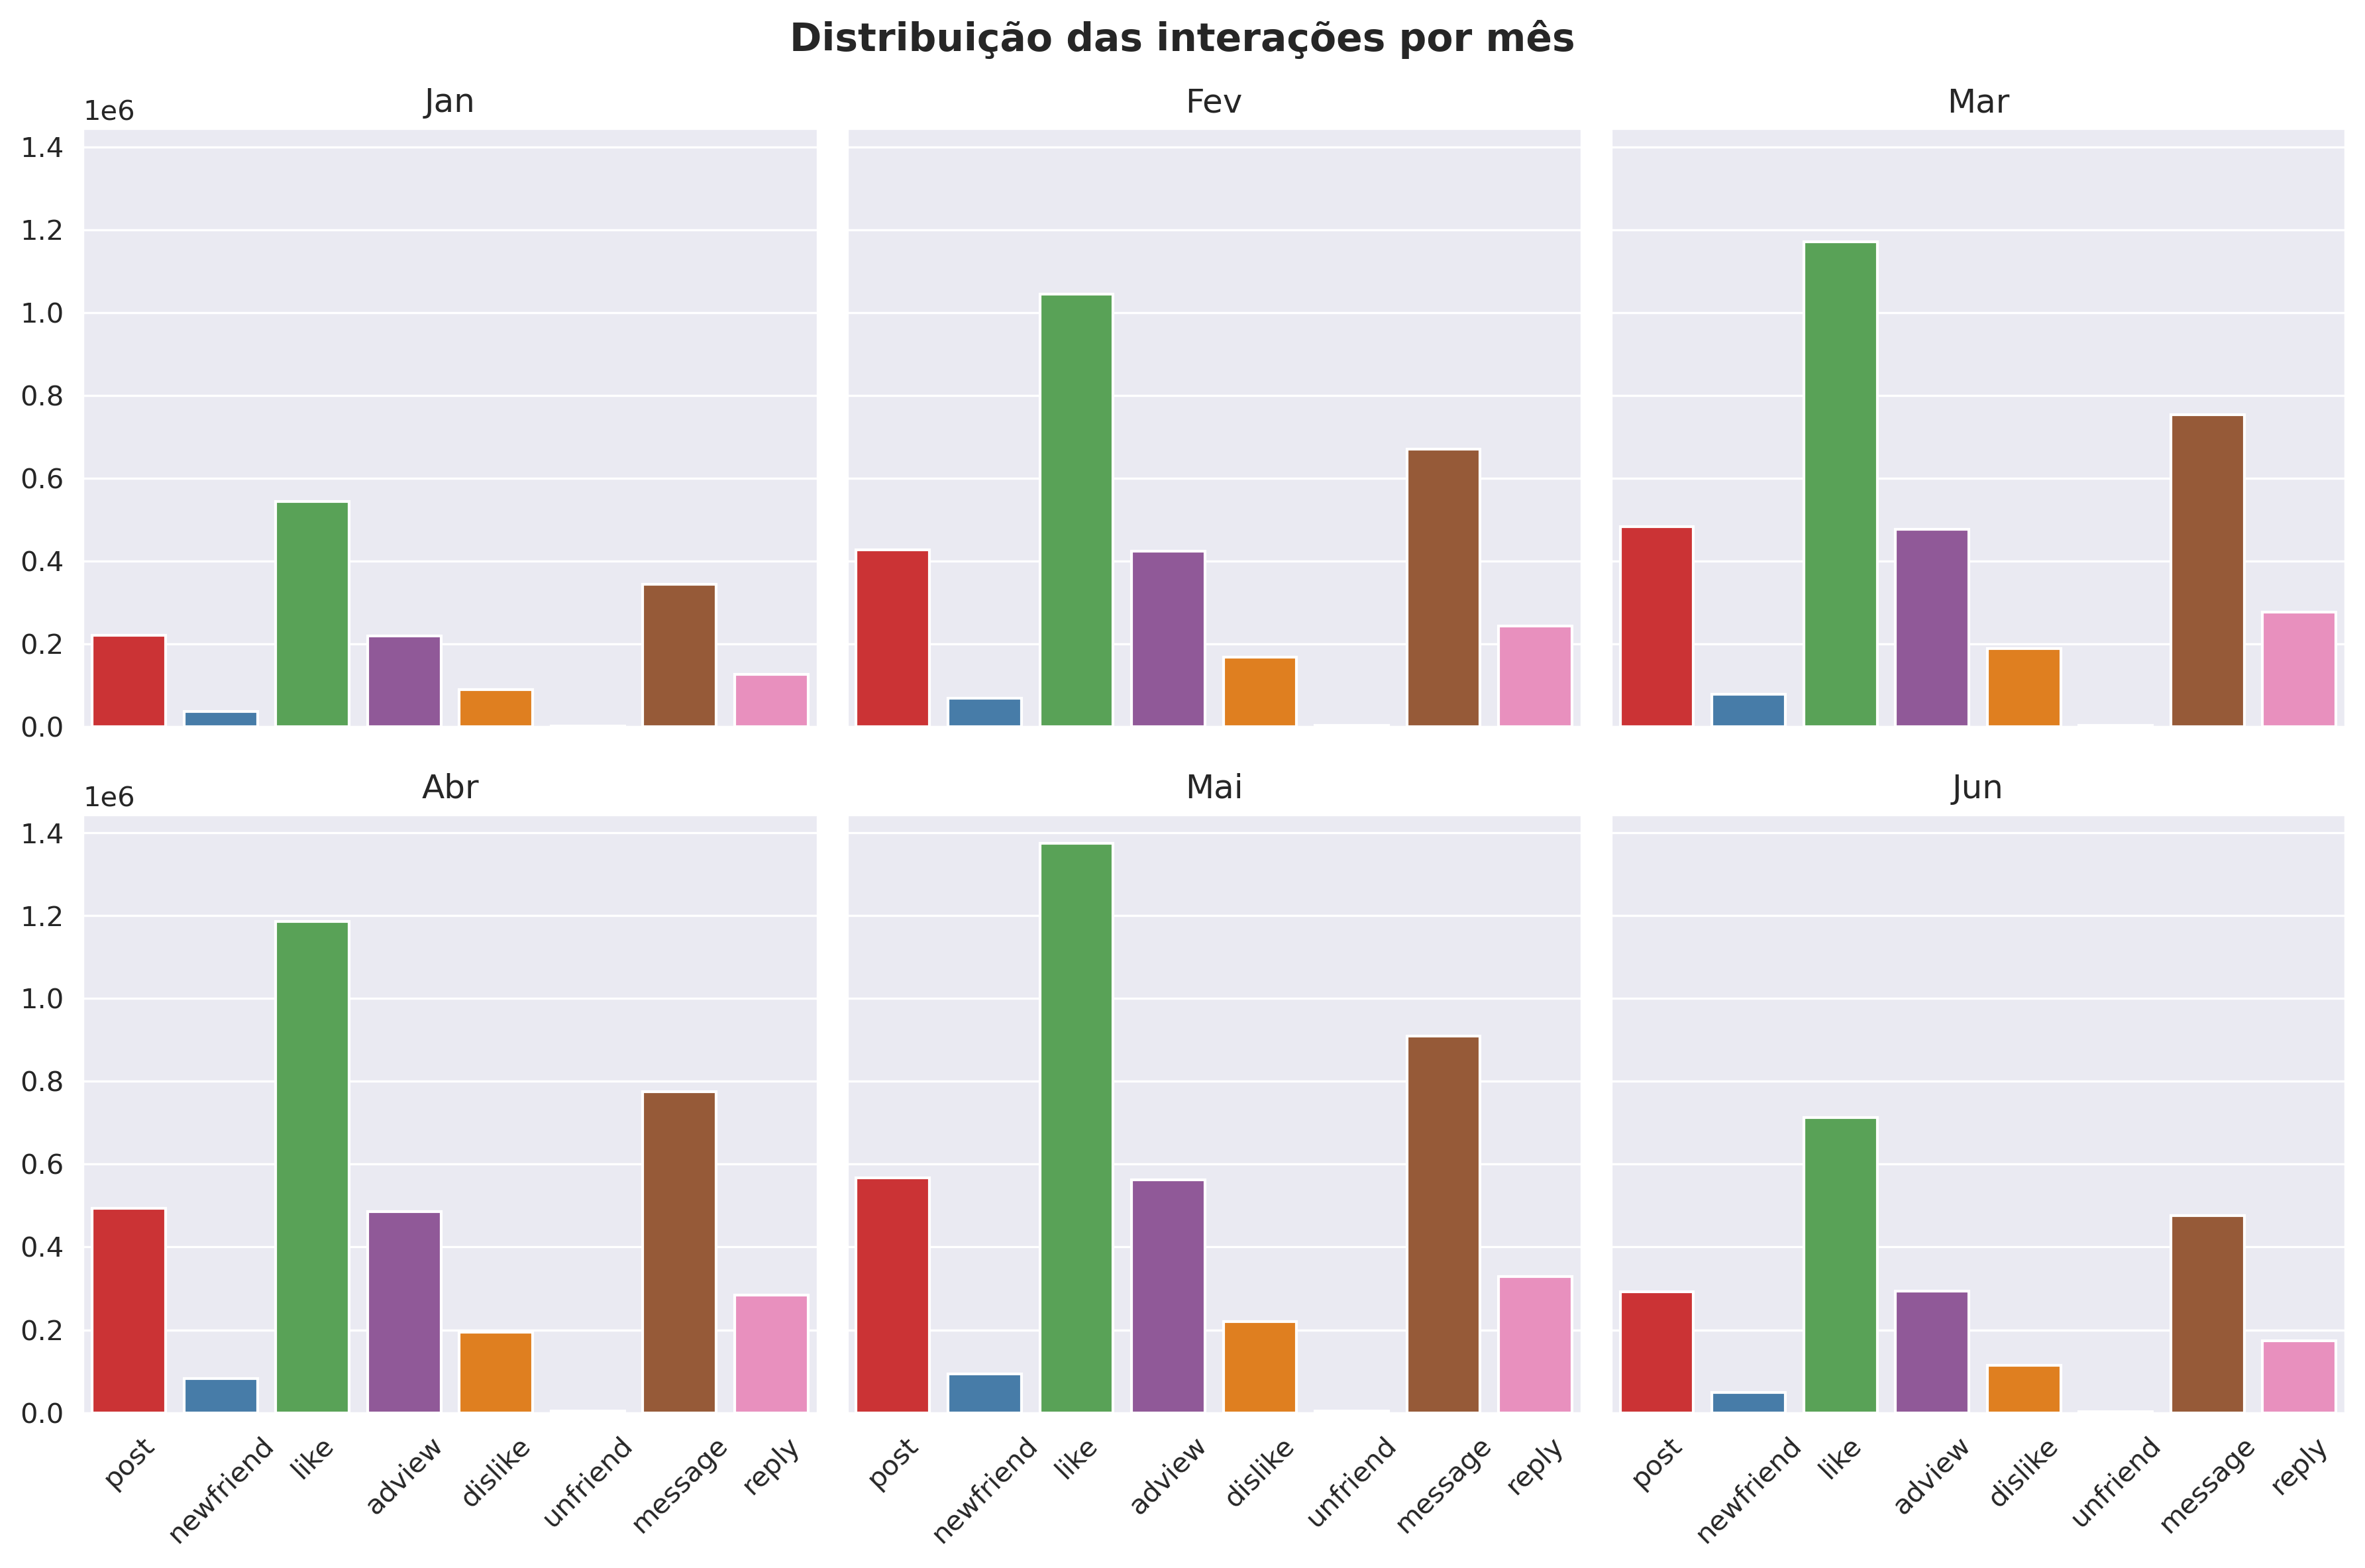

In [51]:
#APAGAR???
f, ax = plt.subplots(nrows=2,ncols=3, sharex = True, sharey = True, figsize=(12,8))
i=0
j=0
for month, group in month_groupby:
    sns.barplot(x=group.event_type_id.value_counts().index, 
                y=group.event_type_id.value_counts().values, 
                ax=ax[i][j], 
                palette = 'Set1')
    
    ax[i][j].set_title(meses[month])
    ax[i][j].set_xticks(ticks = np.arange(0,8), labels = event_type.event_type_name.values, rotation = 45)
    j+=1
    if j==3:
        j=0
        i+=1
plt.suptitle('Distribuição das interações por mês', weight = 'bold', fontsize = 14)
plt.tight_layout()

A proporção entre as diferentes formas de interação possíveis permaneceu relativamente constante durante os meses, o que indica que o comportamento dos usuários não variou durante o período.

## Volume mensal de assinaturas

In [52]:
account_subscription = account.merge(subscription, how = 'left', left_on = 'id', right_on = 'account_id').drop(['id_y', 'id_x'], axis = 1)

In [53]:
account_subscription['start_month'] = account_subscription['start_date'].dt.month
account_subscription['start_day']   = account_subscription['start_date'].dt.day

account_subscription['end_month']   = account_subscription['end_date'].dt.month
account_subscription['end_day']     = account_subscription['end_date'].dt.month

In [54]:
(account_subscription.end_date - account_subscription.start_date).value_counts()

31 days    32549
30 days    12305
29 days    10648
dtype: int64

Todas as assinaturas são de duração de 1 mês.

In [55]:
account_subscription.head()

,channel,date_of_birth,country,account_id,product,start_date,end_date,mrr,start_month,start_day,end_month,end_day
0,appstore2,1948-09-10,CN,1,standard,2020-01-06,2020-02-06,9.99,1,6,2,2
1,appstore2,1948-09-10,CN,1,standard,2020-02-06,2020-03-06,9.99,2,6,3,3
2,appstore2,1948-09-10,CN,1,standard,2020-03-06,2020-04-06,9.99,3,6,4,4
3,appstore2,1948-09-10,CN,1,standard,2020-04-06,2020-05-06,9.99,4,6,5,5
4,appstore2,1948-09-10,CN,1,standard,2020-05-06,2020-06-06,9.99,5,6,6,6


In [56]:
sig_month = account_subscription.groupby('start_month').count()['channel']

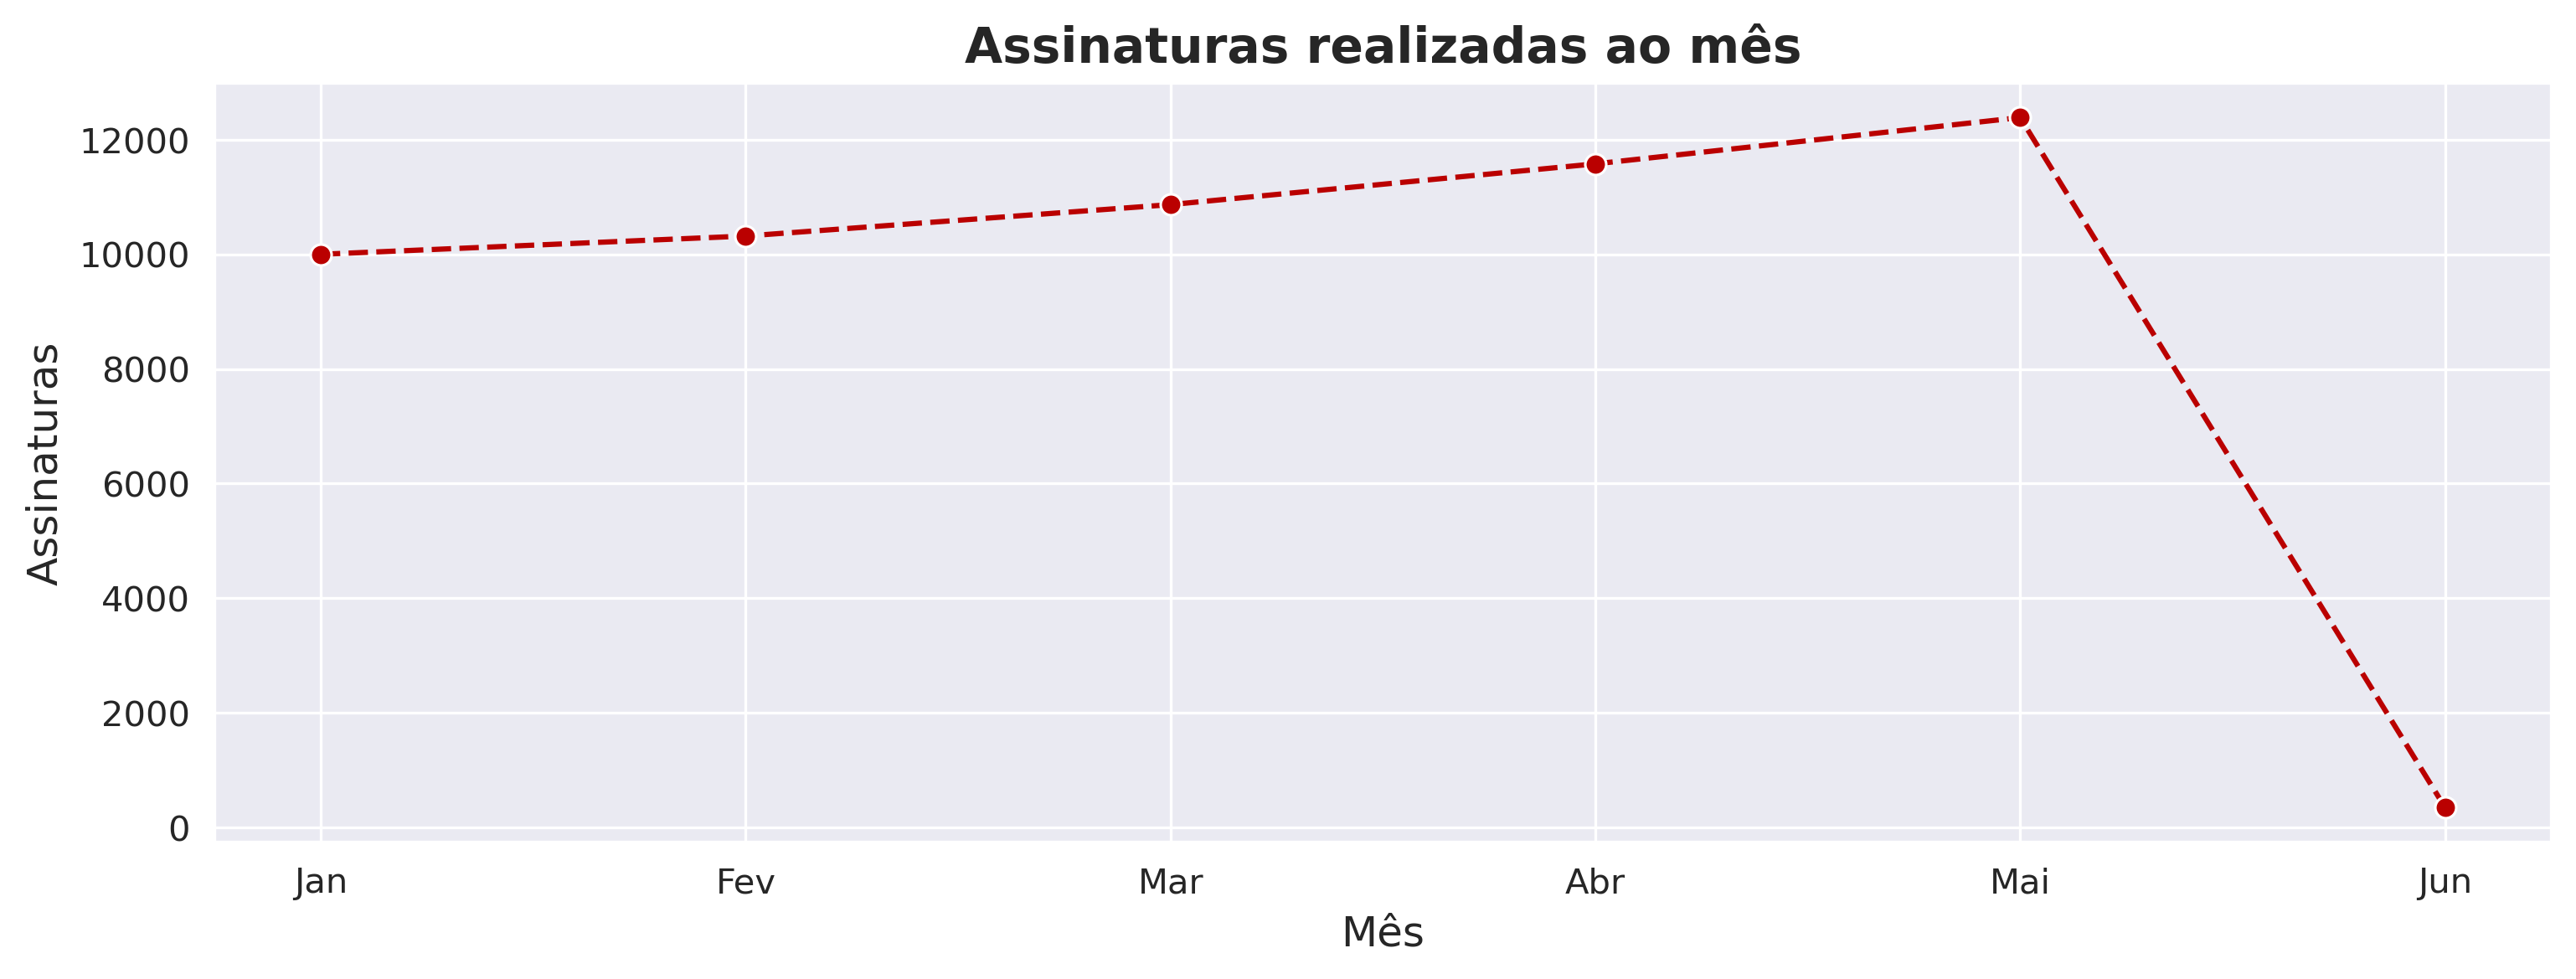

In [57]:
sns.lineplot(x=sig_month.index,
             y=sig_month.values, 
             palette = 'Set1', 
             marker= 'o', 
             color = '#BA0000', 
             linestyle = '--')

plt.xlabel('Mês', fontsize = 12)
plt.ylabel('Assinaturas', fontsize = 12)
plt.xticks(np.arange(1,7), meses.values())
plt.title('Assinaturas realizadas ao mês', fontdict = {'fontsize':14, 'weight':'bold'})
plt.show()

In [ ]:
# Coluna que define se assinatura é nova ou renovada
account_subscription['renew'] = account_subscription.progress_apply(lambda x: x.account_id in (account_subscription[account_subscription.start_month == (x.start_month-1)]['account_id']).values, axis = 1)

 12%|████▎                                | 6519/55502 [00:12<01:14, 653.22it/s]

In [ ]:
account_subscription.sort_values(by='account_id')

## Assinaturas Novas x Renovadas e acesso pelos canais de assinatura

In [ ]:
group_channels = account_subscription.groupby(['start_month','channel']).count()['product'].reset_index()

In [ ]:
f, ax = plt.subplots(nrows = 2, figsize=(12,8),sharex = False, sharey = True)

sns.countplot(data = account_subscription, 
              x='start_month', 
              hue = 'renew', 
              ax = ax[0])

ax[0].legend(labels = ['Nova Assinatura','Renovação'], title = 'Evento')
ax[0].set_xticks(ticks  = np.arange(0,6), labels=['Jan','Fev','Mar','Abr','Mai','Jun'])
ax[0].set_xlabel('')
ax[0].set_ylabel('Assinaturas', fontsize = 12)
ax[0].set_title('Novas Assinaturas x Renovações',fontsize = 14, weight = 'bold')



sns.lineplot(data = account_subscription.groupby(['start_month','channel']).count()['product'].reset_index(), 
             x='start_month', 
             y='product', 
             hue = 'channel', 
             marker = 'o', 
             ax = ax[1])

plt.title('Assinaturas por canal', weight = 'bold', fontsize = 14)
ax[1].set_xlabel('Mês', fontsize = 12)
ax[1].set_ylabel('Assinaturas', fontsize = 12)
ax[1].set_xticks(np.arange(1,7), meses.values())
ax[1].legend(title = 'Canal de Assinatura')

plt.suptitle('Variações do número de assinaturas ao longo do tempo', weight = 'bold', fontsize = 14)
plt.show()

* Como não temos dados anteriores, consideramos as assinaturas do mês de Janeiro como novas assinaturas. É possível constatar que a a maioria das assinaturas ativas vem de renovações de usuários e uma pequena fração incremental de novas assinaturas a cada mês. No último mês, no entanto, não houveram novas assinaturas e a taxa de renovação foi muito abaixo do que vinha sendo observado.

* O segundo gráfico mostra que o canal mais utilizado no momento das assinaturas é a appstore2 seguido pelaappstore1 e a web com o menor apelo.

## Avaliação de Faixa Etária

In [ ]:
account_subscription['age'] = account_subscription.date_of_birth.progress_apply(lambda x: datetime.date.today() - x.date())

In [ ]:
account_subscription['age'] = round(account_subscription.age.dt.days/365,0)

In [ ]:
sns.histplot(account_subscription.age)
plt.title('Distribuição de assinantes por idade', fontdict = {'fontsize':14, 'weight':'bold'})
plt.xlabel('Idade')
plt.ylabel('Assinantes')
plt.show()

O gráfico de idades mostra que há uma distribuição com váris picos em diferentes faixas de idade. Para facilitar a análise, será feito o agrupamento das idades em faixas etárias.

Considerando:
   * Até 19 anos: Adolescentes e jovens
   * Entre 20 e 39 anos: Jovens adultos
   * Entre 40 e 59 anos: Adultos
   * Entre 60 e 80: Idosos
   * Acima de 80: Idosos+

In [ ]:
account_subscription['age_group'] = pd.cut(account_subscription.age, bins=[0,19,40,60,80, 100], labels=['Adolescentes e Jovens','Jovens Adultos','Adultos','Idosos', 'Idosos+'])

In [ ]:
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize = (4,2))
explode = [0.01, 0.01, 0.01, 0.01, 0.01]

plt.pie(account_subscription.drop_duplicates(['account_id'])['age_group'].value_counts().values, 
        labels = account_subscription.drop_duplicates(['account_id'])['age_group'].value_counts().index, 
        colors = colors, 
        autopct='%.0f%%', 
        explode = explode,
        textprops={'fontsize': 5})

plt.title('Distribuição do Público por Faixa Etária',fontsize= 8, weight = 'bold')
plt.show()

## Período total de assinatura por conta

In [ ]:
ltv = subscription.groupby('account_id').agg({'start_date':'min', 'end_date':'max'})

In [ ]:
ltv['period'] = (ltv.progress_apply(lambda x: int((x.end_date - x.start_date).days/30), axis = 1)).astype('category')

In [ ]:
sns.histplot(data=ltv, x='period')
plt.title('Distribuição do período de assinatura por cliente', fontdict = {'fontsize':14, 'weight':'bold'})
plt.xlabel('Tempo de assinatura (meses)')
plt.ylabel('Assinantes')
plt.show()

In [ ]:
ltv['age_group'] = (ltv.index.map(dict(zip(account_subscription.account_id,account_subscription.age_group)))).astype('category')

In [ ]:
sns.countplot(data = ltv, 
              x = 'period', 
              hue = 'age_group')

plt.xlabel('Tempo de assinatura (meses)', fontsize=12)
plt.ylabel('Assinantes', fontsize=12)
plt.title('Período de assinatura em cada faixa etária', fontdict = {'fontsize':14, 'weight':'bold'})
plt.legend(title = 'Faixa Etária')
plt.show()

Não parece haver variação significativa na proporção de assinantes por grupo etário considerando todos os períodos de assiantura.

In [ ]:
ltv_event = ltv.merge(event, how='right', 
                      left_index = True, 
                      right_on = 'account_id')

## Tipos de interações por faixa etária

In [ ]:
sns.countplot(data=ltv_event[['age_group','event_type_id']], 
              x = 'age_group',  
              hue='event_type_id')

plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Interações', fontsize=12)
plt.title('Tipos de interações registradas entre faixas etárias', fontdict = {'fontsize':14, 'weight':'bold'})
plt.legend(event_type.event_type_name.values, title = 'Interação')
plt.show()

## Avaliação de usuários por país

In [ ]:
temp = account.country.value_counts().sort_values(ascending = False)
sns.barplot(x = temp.index, y=temp, order = temp.index)
plt.xlabel('País', fontsize=12)
plt.ylabel('Assinaturas', fontsize=12)
plt.title('Volume de assinaturas por país no período', fontdict = {'fontsize':14, 'weight':'bold'})
plt.tight_layout()
plt.show()

* China e Estados Unidados constituem a maior fração do público assinante do serviço. 
* Vamos avaliar como o volume de assinaturas variou para cada um desses países.

In [ ]:
grouped_countries = [account_subscription[account_subscription.country==ctr] for ctr in account.country.unique() if ctr is not np.nan]

In [ ]:
#Cores para a as séries temporais de cada país no gráfico abaixo

colors = ['#800000', '#FF4500','#CD5C5C','#FFD700', '#B8860B', 
          '#EEE8AA', '#9ACD32','#7CFC00','#006400','#8B4513', 
          '#000000', '#8FBC8F', '#00FA9A','#2E8B57','#2F4F4F',
         '#008080','#00FFFF','#AFEEEE','#4682B4','#191970',
         '#0000FF','#8A2BE2','#4B0082', '#8B008B','#FF00FF','#F5DEB3']

In [ ]:
for n, country in tqdm(enumerate(grouped_countries)):
    cur_country = country.groupby('start_month').count()['country']
    
    ax = sns.lineplot(x=cur_country.index, 
                      y=cur_country, 
                      marker = '*', 
                      label = country.country.iloc[0], 
                      color=colors[n], 
                      linestyle='-')
    
handles, labels = ax.axes.get_legend_handles_labels()
ax.legend_.remove()
ax.figure.legend(handles, labels, ncol=7, loc='upper left', 
                bbox_to_anchor=(0.5, 1.15), frameon=True, title = 'País')

ax.set_xlabel('Mês', fontsize = 12)
ax.set_ylabel('Assinaturas', fontsize = 12)
ax.set_xticks(np.arange(1,7), labels = ['Jan','Fev','Mar','Abr','Mai','Jun'])
plt.title('Variação de assinaturas por país', loc = 'left', fontdict = {'fontsize':14, 'weight':'bold'})
plt.tight_layout()
plt.show()

Todos os países seguiram a mesma tendência no mês de junho e não renovaram suas assinaturas para o próximo mês, o que indica que o churn da plataforma é um fenômeno mundial.

## Avaliação de assinaturas por dia

In [ ]:
event_ts = event.set_index('event_time').resample('D').count()

In [ ]:
event_ts['account_id'].plot(linewidth=2)
plt.ylabel('Assinaturas', fontsize = 12)
plt.xlabel('Mês', fontsize = 12)
plt.title('Novas Assinaturas diárias', 
          fontsize = 14, 
          weight = 'bold')
plt.show()

O fluxo de assinaturas parece não parece ter uma sazonalidade específica, Portanto não parece haver um período do mês mais propenso à ocorrência das assinaturas.

## Avaliação por horário

In [ ]:
hour_event = event[['account_id','event_time']].set_index('event_time').resample('H').count()

In [ ]:
hour_event['hour'] = hour_event.index.hour

In [ ]:
(hour_event.groupby('hour').mean()['account_id']).plot(kind='line', marker = 'd', color = '#006400')
plt.xlim([0,23])
plt.xticks(np.arange(0,24,4))
plt.title('Média de interações por faixa horária', weight = 'bold', fontsize = 14)
plt.xlabel('Hora', fontsize = 12)
plt.ylabel('Interações', fontsize = 12)

plt.axvline(x=6, linestyle = '--', color = 'black')
plt.axvline(x=12, linestyle = '--', color = 'black')
plt.axvline(x=18, linestyle = '--', color = 'black')
plt.text(x=1.75,y=4070, s='Madrugada', fontdict={'weight':'bold'})
plt.text(x=8.25,y=4070, s='Manhã', fontdict={'weight':'bold'})
plt.text(x=14.5,y=4070, s='Tarde', fontdict={'weight':'bold'})
plt.text(x=20,y=4070, s='Noite', fontdict={'weight':'bold'})

plt.show()

In [ ]:
print('O gráfico mostra que o período de pico de interações com maior estabilidade ocorre durante a tarde, das 12:00 às 18:00.')
print(f"No entanto, a média de interações por horário, em geral, é relativamente constante ficando entre {round(hour_event.groupby('hour').mean()['account_id'].min(),0)} e {round(hour_event.groupby('hour').mean()['account_id'].max(),0)} interações por hora.")

## Perfil dos países por grupo etário e canal de assinatura

In [ ]:
age_country = account_subscription.groupby(['country','age_group'])['age'].count().reset_index()

In [ ]:
sns.barplot(data=age_country, x='country',y='age',hue='age_group')
plt.xlabel('País', fontsize = 12)
plt.ylabel('Assinantes', fontsize = 12)
plt.title('Faixa etária de assinantes por país', fontsize = 14, weight = 'bold')
plt.legend(title = 'Faixa Etária')
plt.show()

In [ ]:
channel_country = account_subscription.groupby(['country','channel'])['age'].count().reset_index()

In [ ]:
sns.barplot(data=channel_country, x='country',y='age',hue='channel')
plt.xlabel('País', fontsize = 12)
plt.ylabel('Assinantes', fontsize = 12)
plt.title('Canais de assinatura utilizados por país', fontsize = 14, weight = 'bold')
plt.legend(title = 'Canal de Assinatura')

plt.show()

In [ ]:
channel_age = account_subscription.groupby(['age_group','channel'])['age'].count().reset_index()

In [ ]:
sns.barplot(data=channel_age, x='age_group',y='age',hue='channel')
plt.xlabel('Faixa Etária', fontsize = 12)
plt.ylabel('Assinantes', fontsize = 12)
plt.title('Canais de assinatura utilizados por faixa etária', fontsize = 14, weight = 'bold')
plt.legend(title = 'Canal de Assinatura')
plt.show()

In [ ]:
event.head()